# Embedded ML - Lab 3: Accelerators for ML

Tensor Flow Lite is not only a vehicle to export models to be used in Tensor Flow Lite Micro. It's also an interpreter to run inference on devices that have less resources than servers or standard computers, such as mobile phones, drones, network cameras, etc. In this lab we will use TF Lite to implement an ML application on an embedded platform that features a GPU.

### Learning outcomes


* Explain the differences between a Tensor Flow and a TF Lite environment
* Use the TF Lite API to implement an ML application on an embedded GPU
* Understand the performance differences between TF and TF Lite
* Understand the performance differences between embedded and higher-end GPUs
* Use tools for execution time and memory measurement

### Basic performance measurement

In this lab you'll be required to measure the execution **time** and **memory** consumption of certains code sequences. There many ways of achieving this and you are encouraged to investigate yourself a bit what options are available and how they differ from each other.

When measuring **execution time**, you should think and decide what is the piece of code you are really interested in measuring, and your conclusions must take that into account. Also notice that the shorter time the code takes, the less accurate can be the measurement because any other thing happening in the system will be a significant noise. Besides using more specialized libraries for accurate time measuring, one common trick you can use is to run a short piece of code many times in a loop, measuring the total loop time and diving by the number of iterations. For this lab you could start with the **time.time()** method of the time Python library.

In [ ]:
import time

n=1000000
lista=[0]*n
start = time.time()

# here goes the code you want to measure

sum=0
for i in range(n):
  sum+=i
  lista[i]=sum
end = time.time()
print("Execution time:", (end - start)/n , "seconds and the sum is equal to: ",sum)

Execution time: 3.4264850616455076e-07 seconds and the sum is equal to:  499999500000


With respect to memory consumption, different parts of a program require different amounts of memory. In this lab we are instrested in the maximum amount of memory, or **peak memory**, because it determines an absolute resource requirement that any device that aims to run the code must meet.

For this lab you could start with the **memory_info()** method of psutil Python library.

In [ ]:
import psutil, os


process = psutil.Process(os.getpid())
before = process.memory_info().rss

# here goes the code you want to measure

n=1000000
sum=0
lista=[0]*n
for i in range(n):
  sum+=i
  lista[i]=sum
after = process.memory_info().rss
print(f"Memory increased by {(after - before) / 1024 / 1024:.2f} MB")

Memory increased by -0.21 MB


### TensorFlow Lite workflow

We have already seen the TF Lite basic workflow in Lab 2.2. We will now use TF Lite on an embedded platform that includes a GPU device to understand its capabilities and limitations.

Run the following code on the **Jetson Nano board** and on a **workstation GPU** and compare their **latencies** amd **peak memory** usage. The code **trains** and exports a TF Lite model for classifying the Fashion MNIST dataset.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import time
# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the images to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Class names for the Fashion MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           	'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

model = models.Sequential([
	layers.Flatten(input_shape=(28, 28)),
	layers.Dense(128, activation='relu'),
	layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
          	loss='sparse_categorical_crossentropy',
          	metrics=['accuracy'])
start= time.time()
model.fit(train_images, train_labels, epochs=10)
end= time.time()
train_latency=end-start
print("The latency is equal to:t ",train_latency)
print('\nFinished model training')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7902 - loss: 0.6115
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8629 - loss: 0.3810
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8770 - loss: 0.3361
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8846 - loss: 0.3167
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8931 - loss: 0.2877
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8972 - loss: 0.2761
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9025 - loss: 0.2650
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9080 - loss: 0.2524
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9069 - loss: 0.2469
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9129 - loss: 0.2362
The latency is equal to:t  47.43789315223694

Finished model training


GPU usada en por COlab para entrenamiento.

In [ ]:
!nvidia-smi


Wed Jul  2 19:58:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P0             28W /   70W |     630MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# test model accuracy
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# export model to a keras file
model.save("fmnist.keras")

313/313 - 2s - 6ms/step - accuracy: 0.8759 - loss: 0.3560

Test accuracy: 0.8758999705314636


In [ ]:
# load model from a keras file
from keras.models import load_model

model = load_model("fmnist.keras")

In [ ]:
# convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# save converted model to a file
import pathlib
tflite_model_file = pathlib.Path('fmnist.tflite')
tflite_model_file.write_bytes(tflite_model)

Saved artifact at '/tmp/tmppmh1xl4x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133640683288336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133640683286032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133640683283728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133640683286800: TensorSpec(shape=(), dtype=tf.resource, name=None)


409012

Verify that the model files were exported and use them to run **inference**, both on the Jetson Nano and on a **workstation GPU** using **Tensor Flow**. Contrast **latency** and **peak memory** results too.

In [ ]:
start_inference=time.time()
predictions = model.predict(test_images)
end_inference= time.time()

# Function to plot the image, its true label, and the predicted label
def plot_image(i, predictions_array, true_label, img):
	true_label, img = true_label[i], img[i]
	plt.grid(False)
	plt.xticks([])
	plt.yticks([])

	plt.imshow(img, cmap=plt.cm.binary)

	predicted_label = np.argmax(predictions_array)
	if predicted_label == true_label:
		color = 'blue'
	else:
		color = 'red'

	plt.xlabel(f"{class_names[predicted_label]} ({class_names[true_label]})", color=color)

def plot_value_array(i, predictions_array, true_label):
	true_label = true_label[i]
	plt.grid(False)
	plt.xticks(range(10))
	plt.yticks([])
	thisplot = plt.bar(range(10), predictions_array, color="#777777")
	plt.ylim([0, 1])
	predicted_label = np.argmax(predictions_array)

	thisplot[predicted_label].set_color('red')
	thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted labels, and the true labels
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
	plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
	plot_image(i, predictions[i], test_labels, test_images)
	plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
	plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
#plt.savefig("/content/inference_result.png")  # evitar bloquear por GUI
plt.close()
plt.show()

print(f"The total time in inference is equal to: {end_inference - start_inference:.2f} seconds")



313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
The total time in inference is equal to: 0.72 seconds
Memory increased by 60.01 MB during inference


Medición de la memoria usando tensorFlow.

In [ ]:
import multiprocessing as mp
import psutil
import os
import time
import tensorflow as tf
import numpy as np


from tensorflow.keras.datasets import fashion_mnist
(_, _), (test_images, _) = fashion_mnist.load_data()
test_images = test_images / 255.0
test_images = np.expand_dims(test_images, -1)

MODEL_PATH = "/content/fmnist.keras"

def run_model():
    model = tf.keras.models.load_model(MODEL_PATH)
    _ = model.predict(test_images, verbose=0)

def measure_peak_memory():
    p = mp.Process(target=run_model)
    p.start()

    proc = psutil.Process(p.pid)
    peak = 0

    while p.is_alive():
        try:
            mem = proc.memory_info().rss
            peak = max(peak, mem)
        except psutil.NoSuchProcess:
            break
        time.sleep(0.05)

    p.join()
    print(f" Peak memory usage during inference: {peak / (1024 ** 2):.2f} MB")

measure_peak_memory()



Process Process-1:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipython-input-1-2729141864.py", line 17, in run_model
    model = tf.keras.models.load_model(MODEL_PATH)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py", line 200, in load_model
    raise ValueError(
ValueError: File not found: filepath=/content/fmnist.keras. Please ensure the file is an accessible `.keras` zip file.


 Peak memory usage during inference: 402.04 MB


Finally, run **inference** with **TF Lite** on both platforms and compare with the previous execution's **latency** and **peak memory** usage.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset
(_, _), (test_images, test_labels) = fashion_mnist.load_data()

# Preprocess the test images (normalize and reshape)
test_images = test_images.astype(np.float32) / 255.0

# Select an image for inference
input_image = np.expand_dims(test_images[0], axis=0)

tflite_model_file = "fmnist"
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_file+".tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_image)

# Run the inference
t_start_inference=time.time()
interpreter.invoke()
t_end_inference=time.time()
# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Print the output
print("Output:", output_data)

# Optionally, you can get the predicted class
predicted_class = np.argmax(output_data)
print("Predicted class:", predicted_class)
print(f"The time of inference is equal to: {t_end_inference-t_start_inference:.4f}")

[{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([ 1, 28, 28], dtype=int32), 'shape_signature': array([-1, 28, 28], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall_1:0', 'index': 9, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output: [[3.9750745e-07 1.4474340e-11 4.1214751e-08 9.9203668e-10 1.3444990e-08
  3.9910028e-05 6.9955013e-07 2.8944591e-03 4.6946784e-08 9.9706441e-01]]
Predicted class: 9
The time of inference is equal to: 0.0004


In [ ]:
import multiprocessing as mp
import psutil
import time
import numpy as np
import tensorflow as tf

def run_inference():
    from tensorflow.keras.datasets import fashion_mnist

    (_, _), (test_images, _) = fashion_mnist.load_data()
    test_images = test_images.astype(np.float32) / 255.0
    input_image = np.expand_dims(test_images[0], axis=0)

    interpreter = tf.lite.Interpreter(model_path="fmnist.tflite")
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]['index'], input_image)

    interpreter.invoke()  # Inference

def measure_peak_memory():
    p = mp.Process(target=run_inference)
    p.start()

    proc = psutil.Process(p.pid)
    peak = 0

    while p.is_alive():
        try:
            mem = proc.memory_info().rss
            peak = max(peak, mem)
        except psutil.NoSuchProcess:
            break
        time.sleep(0.05)

    p.join()
    print(f" Peak memory usage: {peak / (1024 ** 2):.2f} MB")

# Ejecutar
measure_peak_memory()


Process Process-2:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipython-input-2-116316455.py", line 14, in run_inference
    interpreter = tf.lite.Interpreter(model_path="fmnist.tflite")
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py", line 470, in __init__
    self._interpreter = _interpreter_wrapper.CreateWrapperFromFile(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: Could not open 'fmnist.tflite'.


 Peak memory usage: 477.12 MB


Consolidate all results in one or more tables or plots and write down your conclusions.

### CNNs on Tensor Flow Lite

Now it's your turn to develop a TF Lite application. This time make sure you train a convolutional model to classify images from a different dataset you choose from Kaggle, Roboflow, Hugging Face or similar, not Mnist, Fashion Mnist nor ImageNet. Now, performance evaluation will focus only on **inference**.

Use the Jetson Board and the workstation to run inference both with Tensor Flow and TF Lite. Measure the **peak memory** and **time** and estimate the **energy** consumed based on the nominal power consumption of each system or chip.

Repeat the experiments without using a GPU and compare the results. Use the following code to disable GPU use in TensorFlow.

In [ ]:
!pip install -q kagglehub

In [ ]:
# Instalar kagglehub si aún no está instalado
!pip install -q kagglehub

import kagglehub
import zipfile
import os

# Descargar dataset (se guarda en ~/.kagglehub automáticamente)
path = kagglehub.dataset_download("ashishjangra27/face-mask-12k-images-dataset")

print(" Dataset descargado en:", path)

# Ruta al archivo ZIP descargado
zip_path = os.path.join(path, "Face Mask Dataset.zip")
ruta_extraida = os.path.join(path, "extraido")

ruta_train = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train"
ruta_test = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test"

print(" Ruta de entrenamiento:", ruta_train)
print(" Ruta de prueba:", ruta_test)



 Dataset descargado en: /kaggle/input/face-mask-12k-images-dataset
 Ruta de entrenamiento: /kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train
 Ruta de prueba: /kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [ ]:
CNN_model= tf.keras.Sequential([
    tf.keras.layers.Conv2D(3, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(3,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
CNN_model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:

# Cargar los datasets desde carpetas
train_ds = tf.keras.utils.image_dataset_from_directory(
    ruta_train,
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    ruta_test,
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    batch_size=32,
    image_size=(128, 128),
    shuffle=False
)

Found 10000 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


Algunas imágenes usadas en el entrenamiento son:

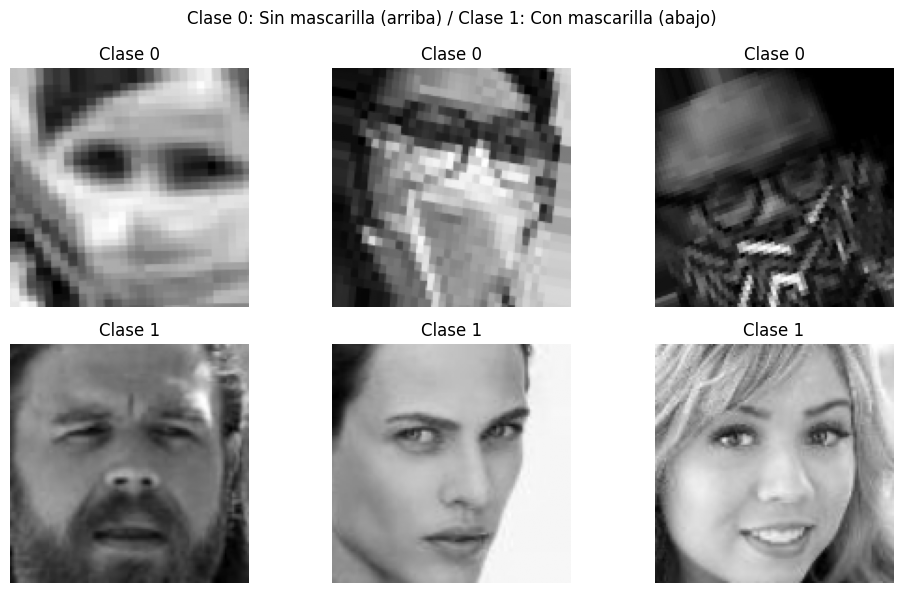

In [ ]:
import matplotlib.pyplot as plt

# Crear listas para almacenar imágenes por clase
imagenes_clase_0 = []
imagenes_clase_1 = []

# Recorrer el dataset para encontrar imágenes de ambas clases
for imagenes, etiquetas in train_ds:
    for img, label in zip(imagenes, etiquetas):
        if label == 0 and len(imagenes_clase_0) < 3:
            imagenes_clase_0.append(img.numpy())
        elif label == 1 and len(imagenes_clase_1) < 3:
            imagenes_clase_1.append(img.numpy())
        if len(imagenes_clase_0) == 3 and len(imagenes_clase_1) == 3:
            break
    if len(imagenes_clase_0) == 3 and len(imagenes_clase_1) == 3:
        break

# Mostrar las imágenes
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle("Clase 0: Sin mascarilla (arriba) / Clase 1: Con mascarilla (abajo)")

for i in range(3):
    axs[0, i].imshow(imagenes_clase_0[i].squeeze(), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title("Clase 0")

    axs[1, i].imshow(imagenes_clase_1[i].squeeze(), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title("Clase 1")

plt.tight_layout()
plt.show()


In [ ]:

CNN_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20
)


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9936 - loss: 0.0174 - val_accuracy: 0.9738 - val_loss: 0.1112
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9982 - loss: 0.0090 - val_accuracy: 0.9657 - val_loss: 0.1216
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9985 - loss: 0.0070 - val_accuracy: 0.9728 - val_loss: 0.1257
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.9973 - loss: 0.0081 - val_accuracy: 0.9688 - val_loss: 0.1640
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9959 - loss: 0.0133 - val_accuracy: 0.9597 - val_loss: 0.2250
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9932 - loss: 0.0165 - val_accuracy: 0.9708 - val_loss: 0.1645
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9963 - loss: 0.0099 - val_accuracy: 0.9728 - val_loss: 0.1721
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9991 - loss: 0.0061 - 

In [ ]:
loss, accuracy = CNN_model.evaluate(test_ds)
print(f"Pérdida (loss): {loss:.4f}")
print(f"Precisión (accuracy): {accuracy:.4f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9735 - loss: 0.1433
Pérdida (loss): 0.1484
Precisión (accuracy): 0.9758


Para hacer inferencia sobre la CNN se usaron las imagenes:

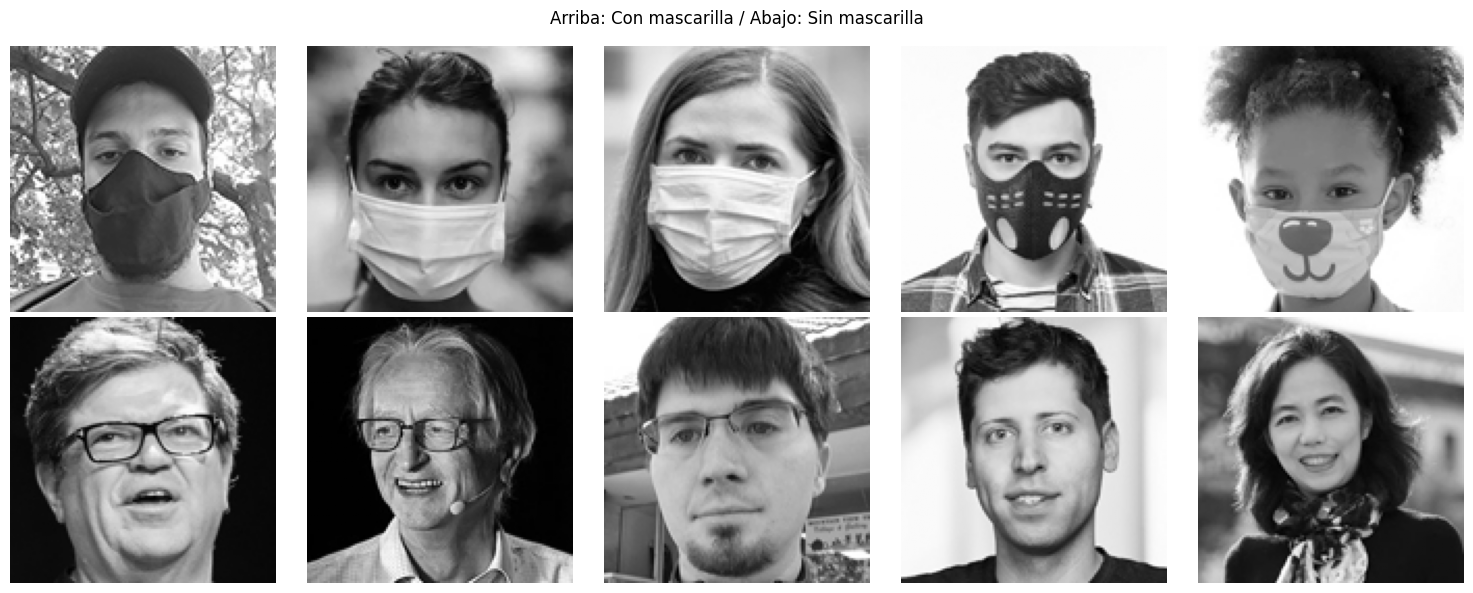

In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

with zipfile.ZipFile("/content/Prueba-5.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

imagenes_with = sorted(os.listdir("/content/Prueba/WithMask"))[:5]
imagenes_without = sorted(os.listdir("/content/Prueba/WithoutMask"))[:5]

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Arriba: Con mascarilla / Abajo: Sin mascarilla")

for i in range(5):
    img_with = load_img(f"/content/Prueba/WithMask/{imagenes_with[i]}", color_mode='grayscale', target_size=(128, 128))
    img_without = load_img(f"/content/Prueba/WithoutMask/{imagenes_without[i]}", color_mode='grayscale', target_size=(128, 128))

    axs[0, i].imshow(img_with, cmap='gray')
    axs[0, i].axis('off')

    axs[1, i].imshow(img_without, cmap='gray')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
CNN_model.save("mascarillas.keras")

In [ ]:
import pathlib

# Ruta del modelo previamente entrenado y guardado en formato .keras
ruta_modelo = 'mascarillas.keras'

# Cargar el modelo desde el archivo .keras
modelo = tf.keras.models.load_model(ruta_modelo)

# Crear un convertidor para transformar el modelo Keras a formato TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(modelo)

# Realizar la conversión a TensorFlow Lite
tflite_model = converter.convert()

# Definir la ruta de salida y guardar el archivo .tflite generado
ruta_salida = pathlib.Path('mascarillas.tflite')
ruta_salida.write_bytes(tflite_model)


Saved artifact at '/tmp/tmpspeesusq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140287521946896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140287520158928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140287457133008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140287457134736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140287457134160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140287457135504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140287457134928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140287457136272: TensorSpec(shape=(), dtype=tf.resource, name=None)


544208

In [ ]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')

# Disable all GPUs
tf.config.set_visible_devices([], 'GPU')

Again, consolidate all results in one or more tables or plots and write down your conclusions.

In [ ]:
import zipfile
import os
import tensorflow as tf
import numpy as np



zip_path = "/content/Prueba-5.zip"
extract_path = "/content/Prueba-5"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
import tensorflow as tf

ruta_inferencia = "/content/Prueba-5/Prueba"

dataset_inferencia = tf.keras.utils.image_dataset_from_directory(
    ruta_inferencia,
    image_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    shuffle=False
)



Found 10 files belonging to 2 classes.


In [ ]:
import time
import numpy as np

modelo_keras = tf.keras.models.load_model("/content/mascarillas.keras")

# Medir tiempo de inferencia total
inicio = time.time()
predicciones = modelo_keras.predict(dataset_inferencia)
fin = time.time()

# Resultado binario
pred_clases = (predicciones > 0.5).astype(int).flatten()

print(" Inferencia completa (.keras)")
print(" Tiempo total:", fin - inicio, "segundos")
print(" Predicciones (0 = Sin mascarilla, 1 = Con mascarilla):", pred_clases.tolist())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
 Inferencia completa (.keras)
 Tiempo total: 0.3118574619293213 segundos
 Predicciones (0 = Sin mascarilla, 1 = Con mascarilla): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Las carácterísticas de la CPU usada en colab es

In [ ]:
!lscpu


Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervisor 

Ejecución en Colab con CPU para el modelo .keras de la CNN

In [ ]:
import time
import numpy as np

modelo_keras = tf.keras.models.load_model("/content/mascarillas.keras")

# Medir tiempo de inferencia total
inicio = time.time()
predicciones = modelo_keras.predict(dataset_inferencia)
fin = time.time()

# Resultado binario
pred_clases = (predicciones > 0.5).astype(int).flatten()

print(" Inferencia completa (.keras)")
print(" Tiempo total:", fin - inicio, "segundos")
print(" Predicciones (0 = Sin mascarilla, 1 = Con mascarilla):", pred_clases.tolist())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
 Inferencia completa (.keras)
 Tiempo total: 1.3059370517730713 segundos
 Predicciones (0 = Sin mascarilla, 1 = Con mascarilla): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Inferencia de la CNN con el archivo tflite.

In [ ]:
import tensorflow as tf
import numpy as np
import time

# Cargar modelo TFLite
interpreter = tf.lite.Interpreter(model_path="/content/mascarillas.tflite")
interpreter.allocate_tensors()

# Obtener detalles de entrada y salida
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Obtener las imágenes del dataset (sin etiquetas)
imagenes = []
for batch in dataset_inferencia:
    imagenes.extend(batch[0].numpy())  # Solo las imágenes
imagenes = np.array(imagenes)

# Asegurar forma correcta (por ejemplo, [N, 128, 128, 1])
if imagenes.shape[-1] != 1:
    imagenes = np.expand_dims(imagenes, -1)

# Inferencia
predicciones = []
inicio = time.time()
for img in imagenes:
    img = np.expand_dims(img, axis=0).astype(np.float32)  # Lote de 1
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    salida = interpreter.get_tensor(output_details[0]['index'])
    predicciones.append(salida[0][0])  # Valor de probabilidad
fin = time.time()

# Convertir a clases binarias
pred_clases = (np.array(predicciones) > 0.5).astype(int)

print(" Inferencia completa (.tflite)")
print(" Tiempo total:", fin - inicio, "segundos")
print(" Predicciones (0 = Sin mascarilla, 1 = Con mascarilla):", pred_clases.tolist())


 Inferencia completa (.tflite)
 Tiempo total: 0.004309177398681641 segundos
 Predicciones (0 = Sin mascarilla, 1 = Con mascarilla): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Ejecución con CPU del modelo tflite de la CNN.

In [ ]:
import tensorflow as tf
import numpy as np
import time

# Cargar modelo TFLite
interpreter = tf.lite.Interpreter(model_path="/content/mascarillas.tflite")
interpreter.allocate_tensors()

# Obtener detalles de entrada y salida
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Obtener las imágenes del dataset (sin etiquetas)
imagenes = []
for batch in dataset_inferencia:
    imagenes.extend(batch[0].numpy())  # Solo las imágenes
imagenes = np.array(imagenes)

# Asegurar forma correcta (por ejemplo, [N, 128, 128, 1])
if imagenes.shape[-1] != 1:
    imagenes = np.expand_dims(imagenes, -1)

# Inferencia
predicciones = []
inicio = time.time()
for img in imagenes:
    img = np.expand_dims(img, axis=0).astype(np.float32)  # Lote de 1
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    salida = interpreter.get_tensor(output_details[0]['index'])
    predicciones.append(salida[0][0])  # Valor de probabilidad
fin = time.time()

# Convertir a clases binarias
pred_clases = (np.array(predicciones) > 0.5).astype(int)

print(" Inferencia completa (.tflite)")
print(" Tiempo total:", fin - inicio, "segundos")
print(" Predicciones (0 = Sin mascarilla, 1 = Con mascarilla):", pred_clases.tolist())


 Inferencia completa (.tflite)
 Tiempo total: 0.005370378494262695 segundos
 Predicciones (0 = Sin mascarilla, 1 = Con mascarilla): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Resumen de resultados y discusión de los mismos.

# Fashion MNIST dataset

<p align="center"><b>Tabla 1: GPU con TensorFlow</b></p>

$$
\begin{array}{|l|c|c|c|}
\hline
\text{GPU} & \text{Latency (Training)} & \text{Latency (Inference)} & \text{Peak Memory (Inference)} \\
\hline
\text{Tesla T4} & 47.4379\ \text{s} & 0.72\ \text{s} & 402.04\ \text{MB} \\
\text{Quadro P5000} & 49.4779\ \text{s} & 0.43\ \text{s} & 1777.77\ \text{MB} \\
\text{GeForce RTX 3050} & 55.8133\ \text{s} & 0.81\ \text{s} & 1174.11\ \text{MB} \\
\text{GeForce GTX 1050 Ti} & 82.1204\ \text{s} & 1.34\ \text{s} & 1052.25\ \text{MB} \\
\text{Jetson Nano} & 244.5837\ \text{s} & - & - \\
\hline
\end{array}
$$



<p align="center"><b>Tabla 2: GPU con TF lite</b></p>
$$
\begin{array}{|l|c|c|}
\hline
\text{GPU} & \text{Latency (Inference)} & \text{Peak Memory (Inference)} \\
\hline
\text{Tesla T4} & 0.0004\ \text{s} & 477.12\ \text{MB} \\
\text{Quadro P5000} & 0.0005\ \text{s} & 1796.14\ \text{MB} \\
\text{GeForce RTX 3050} & 0.0006\ \text{s} & 1145.83\ \text{MB} \\
\text{GeForce GTX 1050 Ti} & 0.0009\ \text{s} & 1070.58\ \text{MB} \\
\text{Jetson Nano} & 0.0002\ \text{s} & 228.34\ \text{MB} \\
\hline
\end{array}
$$


# Face Mask Detection Dataset

https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset


### GPU Specs

---

### 1. [NVIDIA Tesla T4](https://www.techpowerup.com/gpu-specs/tesla-t4.c3316)
- **Arquitectura**: Turing
- **CUDA Cores**: 2560
- **Memory Size**: 16 GB GDDR6
- **TDP Nominal**: 70 W
- **Año de lanzamiento**: 2018

---

### 2. [NVIDIA Quadro P5000](https://www.techpowerup.com/gpu-specs/quadro-p5000.c2864)
- **Arquitectura**: Pascal
- **CUDA Cores**: 2560
- **Memory Size**: 16 GB GDDR5X
- **TDP**: 180 W
- **Año de lanzamiento**: 2016

---

### 3. [NVIDIA GeForce RTX 3050](https://www.techpowerup.com/gpu-specs/geforce-rtx-3050-4-gb.c3744)
- **Arquitectura**: Ampere
- **CUDA Cores**: 2560
- **Memory Size**: 4–8 GB GDDR6
- **TDP**: 90 W
- **Año de lanzamiento**: 2022

---

### 4. [NVIDIA GeForce GTX 1050 Ti](https://www.techpowerup.com/gpu-specs/geforce-gtx-1050-ti.c2885)
- **Arquitectura**: Pascal
- **CUDA Cores**: 768
- **Memory Size**: 4 GB GDDR5
- **TDP**: 75 W
- **Año de lanzamiento**: 2016

---

### 5. [Jetson Nano Board](https://developer.nvidia.com/embedded/jetson-nano-developer-kit)
- **Arquitectura**: Maxwell
- **CUDA Cores**: 128
- **Memory Size**: 4 GB LPDDR4
- **TDP**: 5–10 W
- **Año de lanzamiento**: 2019


### Estimación de la energía

https://www.seas.es/blog/energias-renovables/potencia-y-energia-en-que-se-diferencian/

E = Energía (Joules, J)
P = Potencia (Watts, W)
t = Tiempo (segundos, s)

Energia [J] =Potencia×Tiempo

Energía consumida [kWh] = (Potencia x Tiempo) / 1000

1hora = 60×60= 3600 segundos

Energía consumida [kWh] = Potencia/ (1000 x 3600)

In [ ]:
def estimar_energia(potencia_w, tiempo_s):
    energia_j = potencia_w * tiempo_s
    energia_kwh = energia_j / (1000 * 3600)
    print(f" - Energía consumida: {energia_j:.2f} J ≈ {energia_kwh:.6f} kWh\n")

In [ ]:
#NVIDIA Tesla T4
Tesla_T4_TDP=70
Tesla_T4_time=0.08

# NVIDIA Quadro P5000
QuadroP5000_TDP= 180
QuadroP5000_time=0.10

#NVIDIA GeForce RTX 3050
GeForce_3050_TDP= 90
GeForce_3050_time=0.12

#NVIDIA GeForce GTX 1050 Ti
GeForce_1050_Ti_TDP=75
GeForce_1050_Ti_time=0.14

#Jetson Board
Jetson_TDP=10
Jetson_time=0.13


In [ ]:
print(f"\n Estimación de consumo energético")

print(f"\n NVIDIA Tesla T4")
estimar_energia(Tesla_T4_TDP, Tesla_T4_time)

print(f"\n NVIDIA Quadro P5000")
estimar_energia(QuadroP5000_TDP, QuadroP5000_time)

print(f"\n NVIDIA GeForce RTX 3050")
estimar_energia(GeForce_3050_TDP, GeForce_3050_time)

print(f"\n NVIDIA GeForce GTX 1050 Ti")
estimar_energia(GeForce_1050_Ti_TDP, GeForce_1050_Ti_time)

print(f"\n Jetson Board")
estimar_energia(Jetson_TDP, Jetson_time)



 Estimación de consumo energético

 NVIDIA Tesla T4
 - Energía consumida: 5.60 J ≈ 0.000002 kWh


 NVIDIA Quadro P5000
 - Energía consumida: 18.00 J ≈ 0.000005 kWh


 NVIDIA GeForce RTX 3050
 - Energía consumida: 10.80 J ≈ 0.000003 kWh


 NVIDIA GeForce GTX 1050 Ti
 - Energía consumida: 10.50 J ≈ 0.000003 kWh


 Jetson Board
 - Energía consumida: 1.30 J ≈ 0.000000 kWh



<p align="center"><b>Tabla 3:  Inferencia GPU con TF Lite derivado de la CNN</b></p>
$$
\begin{array}{|l|c|c|c|}
\hline
\text{GPU} & \text{Time} & \text{Peak Memory} & \text{Energy [J]} \\
\hline
\text{Tesla T4} & 0.08\ \text{s} & 356.98\ \text{MB} & 5.60 \\
\text{Quadro P5000} & 0.10\ \text{s} & 189.19\ \text{MB} & 18.00 \\
\text{GeForce RTX 3050} & 0.12 \ \text{s} & 1511.1\ \text{MB} & 10.80 \\
\text{GeForce GTX 1050 Ti} & 0.14\ \text{s} & 1035.03\ \text{MB} & 10.50 \\
\text{Jetson} & 0.13\ \text{s} & 173.97\ \text{MB} & 1.30 \\
\hline
\end{array}
$$


In [ ]:
print(f"\n Estimación de consumo energético de CPU en keras")

#AMD Ryzen 7
AMDRyzen7TDP=35
AMDRyzen7time=0.485

print(f"\n AMD Ryzen 7")
estimar_energia(AMDRyzen7TDP, AMDRyzen7time)

# Intel(R) Xeon(R)
IntelXeon_TDP= 95
IntelXeon_time=1.306


print(f"\n  Intel(R) Xeon(R)")
estimar_energia(IntelXeon_TDP, IntelXeon_time)


#Intel core i5
Inteli5_TDP = 45
Inteli5_time=0.619

print(f"\n Intel core i5 ")
estimar_energia(Inteli5_TDP, Inteli5_time)


 Estimación de consumo energético de CPU en keras

 AMD Ryzen 7
 - Energía consumida: 16.97 J ≈ 0.000005 kWh


  Intel(R) Xeon(R)
 - Energía consumida: 124.07 J ≈ 0.000034 kWh


 Intel core i5 
 - Energía consumida: 27.86 J ≈ 0.000008 kWh



<p align="center"><b>Tabla 4: Inferencia de la CNN con CPU</b></p>

$$
\begin{array}{|l|c|c|c|}
\hline
\text{CPU} & \text{Keras} & \text{TFLite} & \text{Energy [J]} \\
\hline
\text{Ryzen 7} & 0.485\ \text{s} & 0.003\ \text{s} & 16.97 \\
\text{Intel(R) Xeon(R)} & 1.306\ \text{s} & 0.005\ \text{s} & 124.07 \\
\text{Intel Core i5} & 0.619\ \text{s} & 0.003\ \text{s} & 27.86 \\
\hline
\end{array}
$$


**Dataset Fashion MNIST.**

En la tabla 1 se entreno el modelo en todas las estaciones de trabajo disponibles:  

*   Tesla T4 es la GPu del colab
*   Quadro p5000 es estación de trabajo de los computadores del laborario LED
*   NVIDIA GeForce RTX 3050 el computador de Jose
*   NVIDIA GeForce GTX 1050 Ti el computador de Mateo
*   Jetson Nano del cluster servidor

En este caso se observa que la jetson Nano se demoró más entrenando que las demas GPU's, esto era de esperarse dado que, en cierta medida es un sistema con una GPU, memoria y procesador con menor capacidad de computo que las de las demás estaciones de trabajo.

Ahora para la memoria. La métrica “Peak Memory” muestran la máxima cantidad de memoria ocupada durante la inferencia. En la tabla 1 muestra que Quadro p5000 obtuvo el pico de memoria más alto, donde uso casi 1.7 GB y de los computadores personales (RTX 3050 y GTX 1050) alrededor de de 1GB aproximadamente.

Para la Tabla 2, se midio el pico de memoria usado en la jetson en inferencia y se observa que obtuvo el menor consumo de memoria de todas las GPUs, Esto indica su enfoque para aplicaciones optimizadas, lo cual es de suma importancia dado que es un sistema con propósitos embebidos o que buscan la optimización del uso de los recursos disponibles.



Por otro lado, es importante mencionar que la Tabla 2 muestra que la Jetson Nano presentó el menor tiempo de inferencia. No obstante, este resultado puede ser engañoso, ya que es poco coherente que una arquitectura menos potente supere en rendimiento a otras más robustas. Es probable que esta medición se haya visto afectada por factores externos, como el uso de la librería time de Python, que no está diseñada para mediciones de alta precisión, o por la naturaleza del sistema operativo Linux, en donde la multiplexación de procesos puede introducir variaciones temporales no deseadas.

Por tanto, aunque las demás mediciones parecen más consistentes con lo esperado, todas podrían estar sujetas a cierto grado de ruido. Sin embargo, los resultados de estas otras mediciones sí se alinean con lo esperado teóricamente, lo que sugiere que, posiblemente, no fueron afectadas de forma significativa por factores externos. Esto resalta la importancia de emplear herramientas de medición más precisas y entornos de ejecución más controlados al trabajar con tiempos de inferencia tan reducidos.

**Face Mask Detection Dataset (CNN)**

En la Tabla 3, para la inferencia en TensorFlow Lite (TFLite), es importante resaltar que la medición del tiempo incluye etapas previas al proceso de inferencia, a diferencia de la Tabla 4, donde el tiempo medido corresponde exclusivamente al proceso de inferencia. En la Tabla 3 se consideraron los siguientes pasos:

*   cargar imagen
*   preprocesar imagen
*   invoke
*   obtener salida


Esta diferencia metodológica debe tenerse en cuenta al comparar los resultados entre tablas.

Por otro lado, la estimación del consumo energético fue completamente teórica, ya que una medición directa puede verse afectada por diversos factores del entorno, como la cantidad de procesos en ejecución, la actividad de la GPU para tareas gráficas u otras operaciones del sistema operativo.

Por lo tanto, con el fin de garantizar mayor fiabilidad, se optó por realizar el cálculo energético mediante una fórmula basada en los datos de consumo máximo proporcionados por el fabricante, asumiendo así un escenario de peor caso.

Como se observa en la Tabla 4, los tiempos de inferencia suelen ser muy reducidos, lo que afecta en cierta medida la precisión al medir directamente el consumo energético. Por esta razón, se optó por realizar una estimación matemática, utilizando los parámetros proporcionados por el fabricante y considerando el consumo máximo en vatios (W).

También es importante mencionar que para estimar de forma más precisa el consumo energético y la potencia (por ejemplo, en kWh), lo ideal sería medir el tiempo total de ejecución desde que se inicia el programa hasta que finaliza, incluyendo todas las etapas del programa.

En el energía la jetson es la que menor consumo tiene respecto a las demas GPUs. apesar de que no tiene el mejor tiempo de inferencia, por otro lado, esto era de esperarse, dado que la GPU con la que cuenta, esta pensada para aplicaciones embebidas, donde se busca minimizar el consumo energético dado los recursos limitados con que se busca trabajar en dichos campos.



**Resultados de la CNN con CPU**

La Tabla 4 resume los resultados obtenidos durante la inferencia de la red neuronal convolucional cuando se desactivan las GPU disponibles. En ella se observa que los tiempos de inferencia aumentaron considerablemente en comparación con los de la Tabla 3, donde sí se utilizaron las GPU. Incluso la GPU de la Jetson, que fue la más lenta, solo tardó 0.13 segundos, mientras que la CPU Ryzen 7 —la más rápida entre las CPU— necesitó 0.485 segundos para realizar la inferencia sobre los mismos datos. No obstante, cabe resaltar que la CPU Ryzen 7 no solo obtuvo el menor tiempo de inferencia entre las CPU, sino también el menor consumo energético.

#Conclusiones.

* La Jetson, aunque no ofrece el mejor tiempo de inferencia, presenta el menor consumo energético, lo cual la hace ideal para aplicaciones embebidas donde la eficiencia energética es prioritaria y se puede sacrificar en cierta medida la necesidad de computo y precisión.
* El uso de GPU ha representado un avance significativo en el campo de la inteligencia artificial, al actuar como aceleradores. Esto se evidencia en los resultados de las tablas 3 y 4, donde los tiempos de inferencia reflejan cuán ineficiente pueden llegar a ser los sistemas de inteligencia artificial sin el uso de Gpu, es decir, el tiempo necesario de inferencia y entrenamiento para grandes volumenes de datos sería totalmente inviable para aplicaciones reales.
* Para la tabla 2 se corroboró el resultado de la jetson nano de 0.0002 segundos de la inferencia del modelo de fashion mnist, por lo tanto concluimos que la librería para la medición del tiempo ("import time") no esta optimizada para medir tiempos tan pequeños, alrededor de los microsegundos, el cual este tiempo se puede ver afectado por perturbaciones del sistema, inclusive, el mismo sistema operativo puede causar dichas perturbaciones al momento de hacer la medida. Tambien se observo que este tiempo fluctua mucho, lo cual seria mejor hacer varias mediciones y tomar el promedio de ellas o inclusive si se requiere de una mejor medida distar del sistema operativo y dar el 100% de los recusos a la aplicación en curso u otras técnicas que mejoren la fiabilidad.   